In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances as pdist

import networkx as nx
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import xml.etree.ElementTree as ET

### Input paths

In [2]:
in_xml        = '../results/vasculature/sub-01/R/vascular_tree_test.xml'
in_centerline = '../results/vasculature/sub-01/R/vascular_tree_centerline.nii.gz'
in_surface    = '../results/surface_warps/sub-01/R/test.surf.gii'
in_xfm        = '../resources/mevislabSTL2Orig.txt'

### MeVisLab inverse transform

In [3]:
xfm = np.array([[-1.0000000000000000, 0, -1.3183898417423746e-16],
                [6.740754805355331e-33, -1.0000000000000000, -2.7755575615628926e-17],
                [-2.428612866367532e-16, -2.775557561562893e-17, 1.0000000000000000]])

### Vascular system graph

In [4]:
tree = ET.parse(in_xml)
root = tree.getroot()

### Hippocampal surface

In [5]:
surf = nib.load(in_surface)
vertices = surf.darrays[0].data
faces = surf.darrays[1].data

n_vertices = len(vertices)

### Centerline NII

In [6]:
nii = nib.load(in_centerline)
centerline = nii.get_fdata()
xfm_nii = nii.affine
voxel_size = abs(nii.affine[0,0])

In [7]:
voxel_size

0.30000001192092896

### Extract skeleton

In [8]:
x = []
y = []
z = []
d = []

for skeleton in root.iter('Skeleton'):
    coords = skeleton.find('_PropertyContainer').find('PropertyValues').find('Vector3').text 

    x.append(float(coords.split(' ')[0]))
    y.append(float(coords.split(' ')[1]))
    z.append(float(coords.split(' ')[2]))

    diameter = skeleton.find('_PropertyContainer').find('PropertyValues').find('double').text

    d.append(float(diameter))
            
data_skeleton       = np.vstack((x,y,z,d))
data_skeleton[:3,:] = np.dot(xfm,data_skeleton[:3,:])

#### Per edge

In [9]:
edge_diameters = []

for skeleton in root.iter('Skeletons'):
    d = []
    for _skeleton in skeleton.iter('Skeleton'):
        diameter = _skeleton.find('_PropertyContainer').find('PropertyValues').find('double').text
        d.append(float(diameter))
    edge_diameters.append(np.median(d))

### Calculate distances

In [10]:
min_distance         = np.zeros((n_vertices))
closest_diameter     = np.zeros((n_vertices))

In [11]:
for i in range(0,n_vertices):
    dist                = cdist(vertices[i].reshape(1,3), data_skeleton[:3,:].T)
    closest_diameter[i] = data_skeleton[3,:][np.argmin(dist)]
    min_distance[i]     = np.amin(dist)-(0.5*closest_diameter[i])

### Extract nodes

In [12]:
i = []
x = []
y = []
z = []
d = []

for node in root.iter('node'):
    id = node.find('_BaseGraphItem').find('id').text 
    
    i.append(int(id))
    
    coords = node.find('_BaseGraphItem').find('_PropertyContainer').find('PropertyValues').find('Vector3').text 

    x.append(float(coords.split(' ')[0]))
    y.append(float(coords.split(' ')[1]))
    z.append(float(coords.split(' ')[2]))

    diameter = node.find('_BaseGraphItem').find('_PropertyContainer').find('PropertyValues').find('double').text 

    d.append(float(diameter))
            
data_nodes        = np.vstack((i,x,y,z,d))    
data_nodes[1:4,:] = np.dot(xfm,data_nodes[1:4,:])

### Extract root nodes

In [13]:
root_nodes = [int(r.text) for r in root.iter('RootID')]

### Course resolution network edges

Only contains edges between the main (e.g., root and branching) nodes. 

In [14]:
pre_node  = [int(edge.find('PredId').text) for edge in root.iter('edge')]
post_node = [int(edge.find('SuccId').text) for edge in root.iter('edge')]
                                                                 
edges_course  = pd.DataFrame(list(zip(pre_node,post_node)), columns=['pre','post'])

In [15]:
n_nodes = data_nodes.shape[1]
course_network_props_dict = {n: (
    data_nodes[1,n], data_nodes[2,n], data_nodes[3,n], data_nodes[4,n]
) for n in range(n_nodes)}

### Fine resolution network edges

Uses skeleton elements from XML data

In [16]:
# Initate pandas dataframe for nodes and edges
node_id = 0
df_nodes = pd.DataFrame(columns=['x','y','z','diameter'])

edge_id = 0
df_edges = pd.DataFrame(columns=['pre','post','distance'])

# Itererate through edges
for edge in root.iter('edge'):

    # Iterate through elements of skeleton
    ids = None
    per_skeleton = None   
    for skeleton in edge.iter('Skeleton'):
        
        # Parse x,y,z coordinates
        skel_xyz = skeleton.find('_PropertyContainer').find('PropertyValues').find('Vector3').text 
        skel_x   = float(skel_xyz.split(' ')[0])
        skel_y   = float(skel_xyz.split(' ')[1])
        skel_z   = float(skel_xyz.split(' ')[2])
        
        # Transform coordinates
        skel_xfm = np.dot(xfm,np.array((skel_x,skel_y,skel_z)))
        
        # Parse diameter
        diameter = skeleton.find('_PropertyContainer').find('PropertyValues').find('double').text 
        
        df_nodes.loc[node_id] = [skel_xfm[0], skel_xfm[1], skel_xfm[2], float(diameter)]

        # Increase id
        ids = np.hstack((ids, node_id)) if ids is not None else node_id
        node_id += 1

    # Define edges based on collected id's
    for i in ids[:-1]:
        distance = cdist(
            np.array((df_nodes.x[i],df_nodes.y[i],df_nodes.z[i])).reshape(-1,1),
            np.array((df_nodes.x[i+1],df_nodes.y[i+1],df_nodes.z[i+1])).reshape(-1,1)
        )
        df_edges.loc[edge_id] = [i,i+1,distance[0][0]]
        edge_id += 1 

Dataframes need to be cleaned as there will be duplicates near the main nodes

In [17]:
duplicate_entries = df_nodes[df_nodes.duplicated(['x','y','z','diameter'])]

In [18]:
for i in range(0,len(duplicate_entries)):
    duplicates = df_nodes[(df_nodes.x == duplicate_entries.iloc[i].x) &
                          (df_nodes.y == duplicate_entries.iloc[i].y) &
                          (df_nodes.z == duplicate_entries.iloc[i].z) &
                          (df_nodes.diameter == duplicate_entries.iloc[i].diameter)
                         ]
    for d in duplicates.index.values[1:]:
        df_edges = df_edges.replace(d, duplicates.index.values[0])
        df_nodes = df_nodes.drop(d)

### Generate network

Used cleaned dataframes to define network

In [19]:
nodes = np.unique(df_nodes.index.values)
network_props_dict = {n: (
    df_nodes.x[n], df_nodes.y[n], df_nodes.z[n], df_nodes.diameter[n]
) for n in nodes}

In [20]:
G_nodes = df_nodes.index.values

G = nx.Graph()
G.add_nodes_from(G_nodes)
for n in G_nodes:
    G.nodes[n]['position'] = (df_nodes.x[n], df_nodes.y[n], df_nodes.z[n])
    G.nodes[n]['diameter'] = (df_nodes.diameter[n])
    
for e in np.arange(0,df_edges.shape[0]):
    G.add_edge(
        int(df_edges.iloc[e]['pre']),
        int(df_edges.iloc[e]['post']),
        distance=float(df_edges.iloc[e]['distance'])
    )

### Shortest path
Generate shortest path from root nodes and export to matrix for color mapping

In [ ]:
# Identify root nodes based on x, y, z coordinates 

root_node_ids = []
for root_node in root_nodes:
    x = data_nodes[data_nodes[0,:]==root_node,1]
    y = data_nodes[data_nodes[0,:]==root_node,2]
    z = data_nodes[data_nodes[0,:]==root_node,3]
    

In [21]:
import time

## Define source node
# Preferebaly one of the root nodes
source_node = 0

# Calculate shortest path from source node to each other connected node
shortest_path_from_root = nx.shortest_path(G, source=source_node, weight='distance')

# Initiate array for filling with calculated distances
distance_to_root = np.zeros((len(G.nodes)))

# Iterate through each connected node and its path to the source node
tic = time.perf_counter()

for node, path in shortest_path_from_root.items():
    
    # Find index of node
    node_index = np.where(G_nodes == node)[0][0]
    
    # Skip source node
    if node != source_node:
        
        mask = list(zip(path[:-1], path[1:]))

        df_x = pd.MultiIndex.from_frame(df_edges[['pre','post']])
        df_y = pd.MultiIndex.from_frame(df_edges[['post','pre']])
        
        dist_x = sum(df_edges[df_x.isin(mask)].distance.values)
        dist_y = sum(df_edges[df_y.isin(mask)].distance.values)

        distance_to_root[node_index] = dist_x + dist_y        

toc = time.perf_counter()
print(f"Finished in {toc - tic:0.4f} seconds")

Finished in 23.6849 seconds


### Plot using plotly

In [22]:
import matplotlib as mpl
from matplotlib import cm
norm = mpl.colors.Normalize(vmin=0.3, vmax=1.5)
viridis = cm.get_cmap('viridis')

Some global plotly settings

In [26]:
# Adjust camera position
camera = dict(
    eye=dict(x=-1, y=2, z=0)
)

# Hide axis planes
scene = dict(
    xaxis = dict(showbackground=False, visible=False),
    yaxis = dict(showbackground=False, visible=False),
    zaxis = dict(showbackground=False, visible=False)
)

# Set margins
margin = dict(l=0, r=0, b=0, t=0)

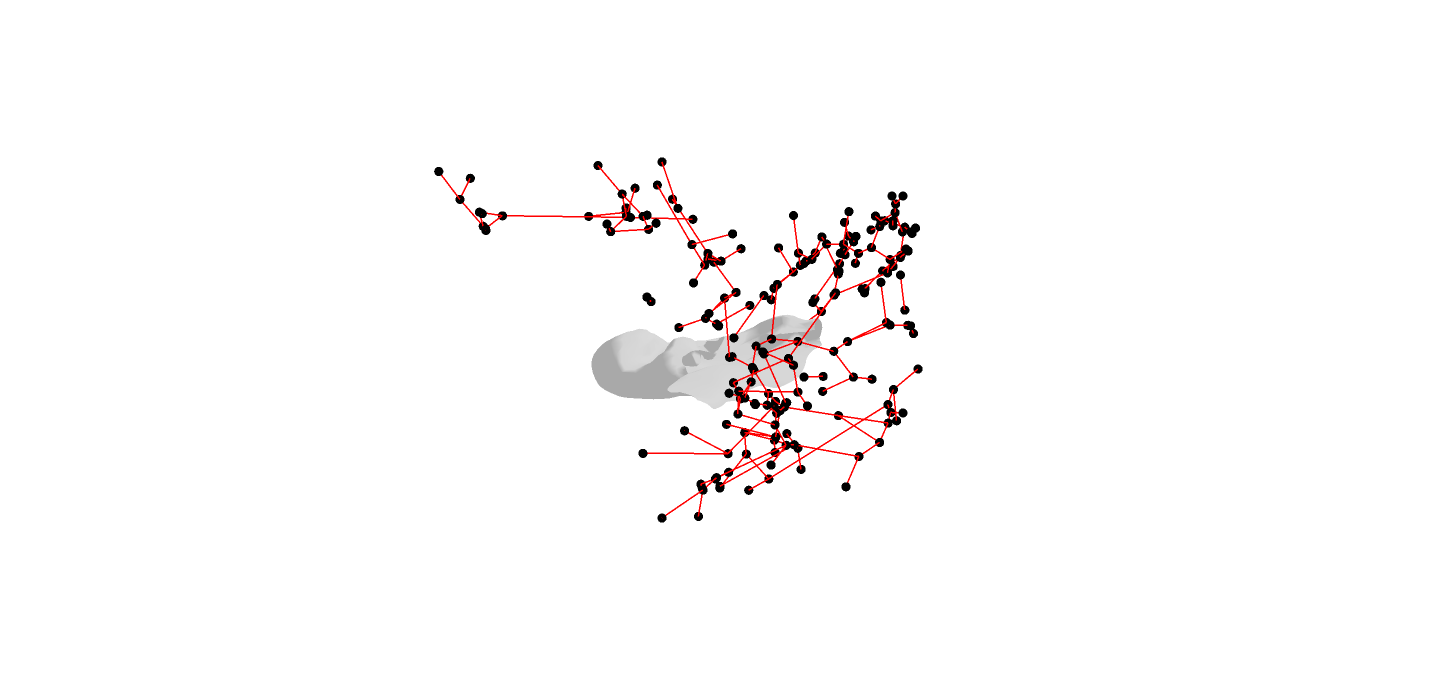

In [27]:
fig = go.Figure()

fig = go.Figure(data=[go.Mesh3d(
    x=vertices[:,0], 
    y=vertices[:,1], 
    z=vertices[:,2], 
    i=faces[:,0], 
    j=faces[:,1], 
    k=faces[:,2], 
    color='lightgray')])

fig.add_trace(go.Scatter3d(
    x=data_nodes[1,:],
    y=data_nodes[2,:],
    z=data_nodes[3,:],
    mode='markers',
    marker=dict(
        size=3,
        color='black',
    )))

for i, j in zip(edges_course['pre'], edges_course['post']):
    x = np.array((course_network_props_dict[i-1][0], course_network_props_dict[j-1][0]))
    y = np.array((course_network_props_dict[i-1][1], course_network_props_dict[j-1][1]))
    z = np.array((course_network_props_dict[i-1][2], course_network_props_dict[j-1][2]))
    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines',
            line=dict(
                width=3,
                color='red'
            )            
        )
    )

fig.update_layout(
    width=800,
    height=700,
    scene = scene,
    scene_aspectmode='data',
    scene_camera=camera,
    margin=margin,
    showlegend=False,
    hovermode=False
)

fig.write_json("vascular_tree_course.json")
fig.show()

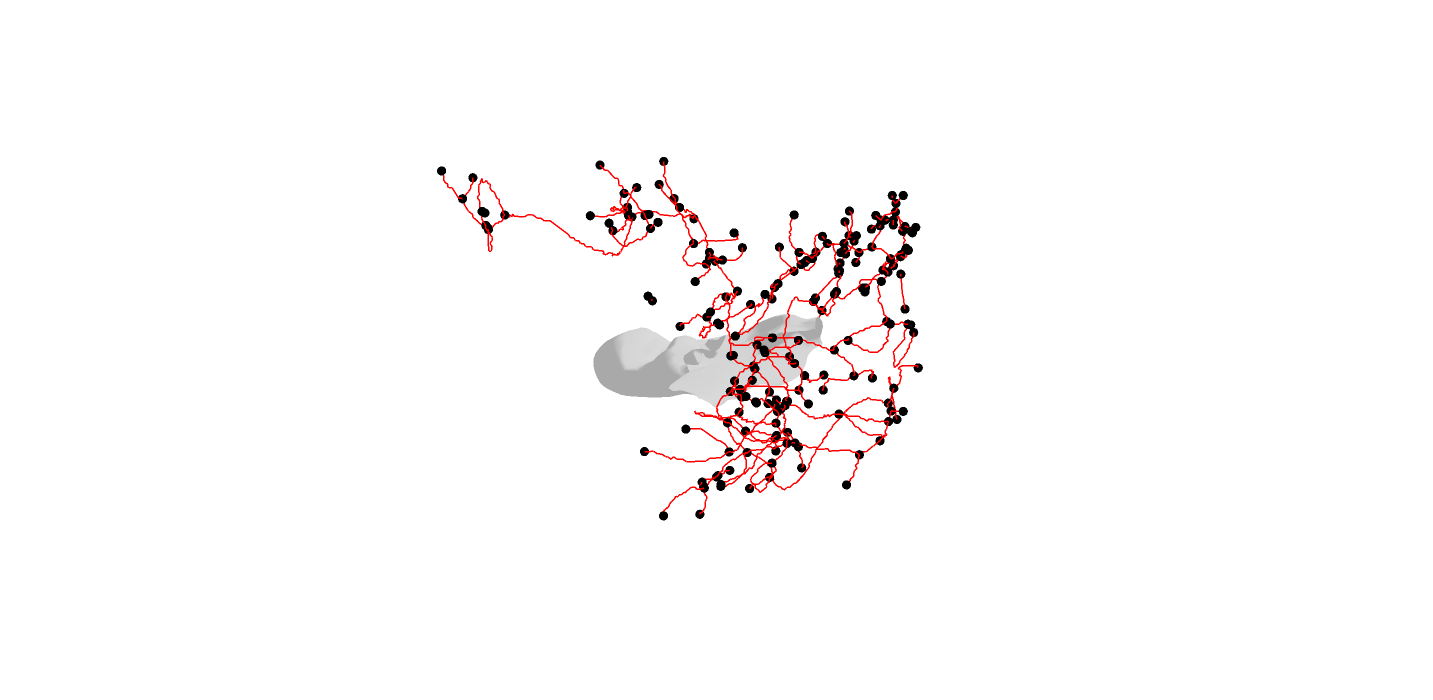

In [28]:
fig = go.Figure()

fig = go.Figure(data=[go.Mesh3d(
    x=vertices[:,0], 
    y=vertices[:,1], 
    z=vertices[:,2], 
    i=faces[:,0], 
    j=faces[:,1], 
    k=faces[:,2], 
    color='lightgray')])

fig.add_trace(go.Scatter3d(
    x=data_nodes[1,:],
    y=data_nodes[2,:],
    z=data_nodes[3,:],
    mode='markers',
    marker=dict(
        size=3,
        color='black',
    )))

for i,j in enumerate(G.edges()):
    x = np.array((network_props_dict[j[0]][0], network_props_dict[j[1]][0]))
    y = np.array((network_props_dict[j[0]][1], network_props_dict[j[1]][1]))
    z = np.array((network_props_dict[j[0]][2], network_props_dict[j[1]][2]))
    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines',
            line=dict(
                width=3,
                color='red'
            )            
        )
    )
    
fig.update_layout(
    width=800,
    height=700,
    scene = scene,
    scene_aspectmode='data',
    scene_camera=camera,
    margin=margin,
    showlegend=False,
    hovermode=False
)

fig.write_json("vascular_tree_fine.json")
fig.show()

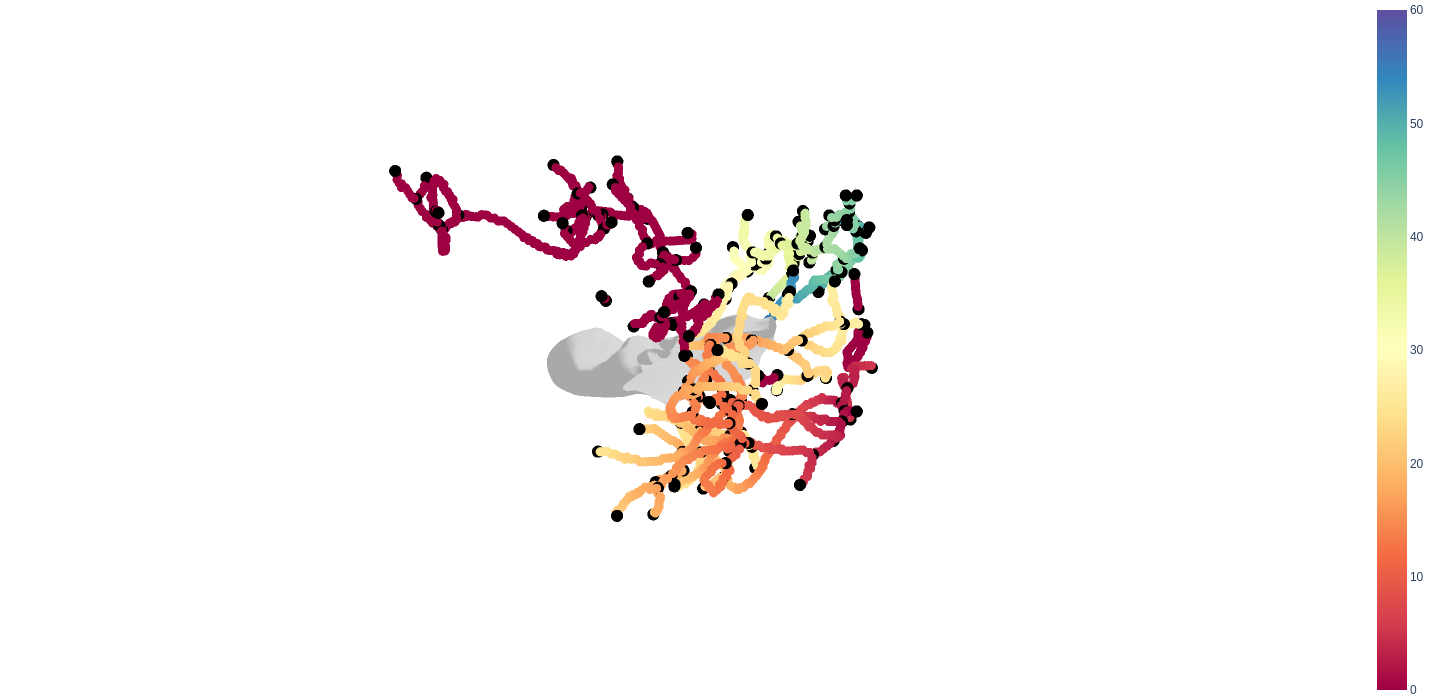

In [30]:
fig = go.Figure(data=[go.Mesh3d(
    x=vertices[:,0], 
    y=vertices[:,1], 
    z=vertices[:,2], 
    i=faces[:,0], 
    j=faces[:,1], 
    k=faces[:,2], 
    color='lightgray',
    #intensity=min_distance,
    #colorscale='Viridis',
    #cmax=1.5,
    #cmin=0.3,    
    showscale=False)])

fig.add_trace(go.Scatter3d(
    x=df_nodes.x, 
    y=df_nodes.y, 
    z=df_nodes.z,
    mode='markers',
    marker=dict(
        size=3,
        color=distance_to_root,
        colorscale='Spectral',
        cmax=60,
        cmin=0,
        showscale=True
    )))

fig.add_trace(go.Scatter3d(
    x=data_nodes[1,:],
    y=data_nodes[2,:],
    z=data_nodes[3,:],
    mode='markers',
    marker=dict(
        size=4,
        color='black',
    )))

fig.update_layout(
    width=800,
    height=700,
    scene = scene,
    scene_aspectmode='data',
    scene_camera=camera,
    margin=margin,
    showlegend=False,
    hovermode=False
)

fig.write_json("vascular_tree_colorcoded.json")
fig.show()

In [ ]:
## To save as vector image use Orca, e.g.:
# /home/rhaast/.local/bin/orca graph vascular_tree_course.json -o vascular_tree_course -f pdf